In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import re
from google.colab import files

In [ ]:
files.upload()

Saving dataset.csv to dataset.csv


{'dataset.csv': b'Sentences,Labels\nwarung dimiliki pengusaha pabrik tahu sudah puluhan tahun terkenal membuat tahu putih bandung   tahu berkualitas   dipadu keahlian memasak   dipadu kretivitas   jadilah warung menyajikan menu utama berbahan tahu   ditambah menu umum seperti ayam   semuanya selera indonesia   harga cukup terjangkau   jangan lewatkan tahu bletoka nya   kalah yang asli tegal  ,1\nmohon ulama lurus k212 mmbri hujjah partai apa harus diwlh suara islam pecah pecah,1\nlokasi strategis jalan sumatera bandung   tempat nya nyaman terutama sofa lantai 2   paella nya enak   sangat pas dimakan minum bir dingin   appetiser nya enak enak  ,1\nbetapa bahagia nya diri saat unboxing paket barang nya bagus   menetapkan beli  ,1\nduh   jadi mahasiswa jangan sombong dong   kasih kartu kuning segala   belajar dulu baik   usahlah ikut ikut politik   sudah selesai kuliah nya mau ikut politik tidak telat   dasar mahasiswa  ,0\nmakanan beragam   harga makanan food stall ditambahkan 10   di ka

In [ ]:
data = pd.read_csv('/content/dataset.csv')

#Show 5 data
data.head()


,Sentences,Labels
0,warung dimiliki pengusaha pabrik tahu sudah pu...,1
1,mohon ulama lurus k212 mmbri hujjah partai apa...,1
2,lokasi strategis jalan sumatera bandung temp...,1
3,betapa bahagia nya diri saat unboxing paket ba...,1
4,duh jadi mahasiswa jangan sombong dong kas...,0


In [ ]:
data.tail(10)

,Sentences,Labels
5209,rapat perdana pembentukan tim koalisi kebhinek...,Netral
5210,2 kali resto resto terbilang unik gaya tra...,Positif
5211,jujur tempat posisi enak banget buat diet lama...,Positif
5212,ah payah banget manchester city kalah dikandan...,Hate Speech
5213,membicarakan soal kampung daun tempat nya sa...,Positif
5214,akhirnya memutuskan mengunjungi restoran untuk...,Positif
5215,apa apa terkadang membuat kesalahan siapapun m...,Positif
5216,rm ayam goreng brebes menyediakan berbagai m...,Positif
5217,hari gue belum menyesal pilih jokowi ahok ...,Hate Speech
5218,hari sabtu pergi lembang bandung liburan lal...,Positif


In [ ]:
!pip install sastrawi

In [ ]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

In [ ]:
import string, re
def preprocess_data (text):
  #lower text
  text = text.lower()

  #hapus tanda baca
  remove = string.punctuation
  translator = str.maketrans(remove, ' '*len(remove))
  text = text.translate(translator)

  #hapus ASCII dan UNICODE
  text = text.encode('ascii', 'ignore').decode('utf-8')
  text = re.sub(r'[^\x00-\x7f]','r',text)

  #remove newline
  text = text.replace('\n', ' ')
  
  #stopword
  stop = stopword.remove(text)

  return text

In [ ]:
data["Sentences"]= data['Sentences'].apply(preprocess_data)

In [ ]:
data['Labels'].value_counts()

Positif        3076
Hate Speech    1611
Netral          532
Name: Labels, dtype: int64

In [ ]:
data['Labels'] = data['Labels'].replace(["Netral", "Positif"], 1)
data['Labels'] = data['Labels'].replace(["Hate Speech"], 0)

In [ ]:
data['Labels'].value_counts()

1    3608
0    1611
Name: Labels, dtype: int64

In [ ]:
data.to_csv(r'/content/dataset.csv' , index=False)

In [ ]:
files.download('dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
max_features = 3000
max_len = 200

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['Sentences'].values)
X = tokenizer.texts_to_sequences(data['Sentences'].values)
X = pad_sequences(X, max_len) 

Y = pd.get_dummies(data['Labels']).values

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 2021)

In [ ]:
embed_dim = 256
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length =X.shape[1]))
model.add(SpatialDropout1D(0.4))
#model.add(LSTM(100))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
#model.add(LSTM(1024,recurrent_dropout=0.2, return_sequences=True))
#model.add(LSTM(512,recurrent_dropout=0.2, return_sequences=True))
#model.add(LSTM(256,recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(256,recurrent_dropout=0.2))
#model.add(LSTM(64,recurrent_dropout=0.2))
model.add(Dense(2,activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 256)          768000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 256)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 200, 196)          355152    
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               463872    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 1,587,538
Trainable params: 1,587,538
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
batch_size = 512

history=model.fit(X_train, Y_train, epochs = 20, batch_size=batch_size, validation_data=(X_test, Y_test), callbacks = [callbacks])

Epoch 1/20
9/9 [==============================] - 20s 2s/step - loss: 0.6816 - accuracy: 0.6498 - val_loss: 0.6288 - val_accuracy: 0.6810
Epoch 2/20
9/9 [==============================] - 15s 2s/step - loss: 0.6353 - accuracy: 0.6939 - val_loss: 0.6336 - val_accuracy: 0.6810
Epoch 3/20
9/9 [==============================] - 15s 2s/step - loss: 0.6185 - accuracy: 0.6939 - val_loss: 0.6365 - val_accuracy: 0.6810
Epoch 4/20
9/9 [==============================] - 15s 2s/step - loss: 0.6196 - accuracy: 0.6939 - val_loss: 0.6248 - val_accuracy: 0.6810
Epoch 5/20
9/9 [==============================] - 15s 2s/step - loss: 0.6152 - accuracy: 0.6939 - val_loss: 0.6234 - val_accuracy: 0.6810
Epoch 6/20
9/9 [==============================] - 15s 2s/step - loss: 0.6116 - accuracy: 0.6939 - val_loss: 0.6212 - val_accuracy: 0.6810
Epoch 7/20
9/9 [==============================] - 15s 2s/step - loss: 0.6055 - accuracy: 0.6939 - val_loss: 0.6131 - val_accuracy: 0.6810
Epoch 8/20
9/9 [==================

In [ ]:
model.save('aplod_version_2.h5')

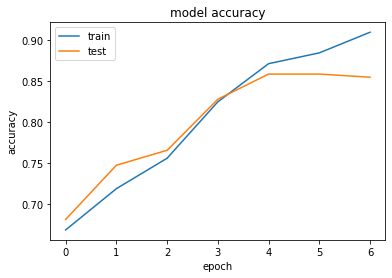

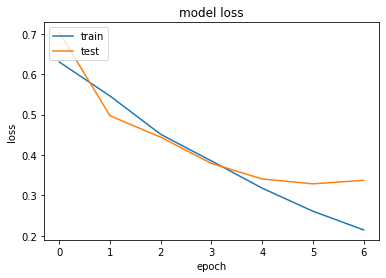

In [ ]:
import matplotlib.pyplot as plt


# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
files.download('aplod_version_2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>